In [22]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io

sys.path.append("../src/")
from sarra_py import *

In [23]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0

In [24]:
grid_width = 1
grid_height = 1
date_start = datetime.date(2012,4,1)
duration = 365

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# simulated data from SARRA-H for comparison purposes
file_df_sim = "simu_AG3US20124.txt"

In [25]:
# Read YAML file
with open(os.path.join('../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()

with open(os.path.join('../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [26]:
# loading weather data and rain data exported from SARRA-H
# df weather
df_weather = pd.read_csv(os.path.join('../data/weather/',file_df_weather), sep="\t", decimal=",", skiprows=1)
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"] >= date_start) & (df_weather["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather["TMoy"] = ((df_weather["TMin"] + df_weather["TMax"]) / 2) 

# df rain
df_rain = pd.read_csv(os.path.join('../data/rain/',file_df_rain), sep="\t", decimal=",", skiprows=1)
df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_rain = df_rain[(df_rain["Jour"] >= date_start) & (df_rain["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

# df ET0
df_ET0 = pd.read_csv(os.path.join('../data/et0/',file_df_ET0), sep="\t", decimal=",", skiprows=1)
df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_ET0 = df_ET0[(df_ET0["Jour"] >= date_start) & (df_ET0["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")
df_weather["ET0"] = df_weather["Eto"] # pour code qui appelle Eto/ET0

# df irrig
df_irrig = pd.read_csv(os.path.join('../data/irrig/',file_df_irrig), sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_irrig = df_irrig[(df_irrig["Jour"] >= date_start) & (df_irrig["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

df_weather

,CodeStation,Jour,TMax,TMin,TEMP,HMax,HMin,HMoy,Vt,Ins,IRRAD,ETP,RAIN,Eto,ET0,Irrigation
0,US0001,2012-01-01,2.2,-4.9,-1.35,NaN,NaN,68.5,9.0,NaN,6.4,NaN,0.0,1.327556,1.327556,0.0
1,US0001,2012-01-02,-3.8,-11.0,-7.40,NaN,NaN,69.5,5.8,NaN,8.7,NaN,0.0,0.803459,0.803459,0.0
2,US0001,2012-01-03,2.8,-13.5,-5.35,NaN,NaN,73.0,2.9,NaN,7.3,NaN,0.0,0.546349,0.546349,0.0
3,US0001,2012-01-04,6.9,-2.0,2.45,NaN,NaN,77.0,4.6,NaN,7.9,NaN,0.0,0.595346,0.595346,0.0
4,US0001,2012-01-05,17.2,-1.3,7.95,NaN,NaN,61.4,3.8,NaN,8.3,NaN,0.0,1.578527,1.578527,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,US0001,2012-12-26,-8.8,-18.1,-13.45,NaN,NaN,88.1,3.2,NaN,8.6,NaN,0.0,0.137895,0.137895,0.0
361,US0001,2012-12-27,-5.3,-15.0,-10.15,NaN,NaN,93.9,2.2,NaN,4.5,NaN,0.0,0.090081,0.090081,0.0
362,US0001,2012-12-28,-3.3,-10.4,-6.85,NaN,NaN,98.9,2.4,NaN,4.5,NaN,0.5,0.043369,0.043369,0.0
363,US0001,2012-12-29,-7.7,-14.6,-11.15,NaN,NaN,95.9,3.9,NaN,7.6,NaN,0.0,0.203795,0.203795,0.0


# Run

In [27]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

In [28]:
data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
data = InitSup2(data, grid_width, grid_height, duration, df_weather)
data = EvalPar(data)

for j in tqdm(range(duration)):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python


    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    #print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


  0%|          | 0/365 [00:00<?, ?it/s]/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:171: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:522: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:856: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:908: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j] / data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:1038: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum

# Comparaison avec SARRA-H

In [29]:
df_gt = pd.read_csv(os.path.join('../data/sim/',file_df_sim), sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

In [30]:
def graph_comparison(var_gt, var_sim):

    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    ax1 = plt.subplot()
    l1, = ax1.plot(df_weather["Jour"], data["numPhase"][0,0,:], color='black', label="sim")

    ax2 = ax1.twinx()
    l2, = ax2.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label=var_sim+" (sim)")
    l3, = ax2.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label=var_gt+" (sarrah)")

    # plt.plot(df_weather["Jour"], data["numPhase"][0,0,:], label="numPhase", alpha=0.5)
    # plt.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label=var_sim+" (sim)")
    # plt.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label=var_gt+" (sarrah)")
    
    plt.legend([l1, l2, l3], ["numPhase",var_sim+" (sim)", var_gt+" (sarrah)"])
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [31]:
def compute_earliest_diff(var_gt, var_sim, tol=10E-6):
    try:
        df_gt_2 = df_gt
        df_gt_2 = df_gt_2.merge(pd.DataFrame({"Jour":df_weather["Jour"],var_sim:data[var_sim][0,0,:]}), left_on="Jour", right_on="Jour")
        df_gt_2["delta"] = np.abs(df_gt_2[var_sim] - df_gt_2[var_gt])
        df_gt_2["signif"] = False
        df_gt_2["signif"] = df_gt_2.apply(lambda x: x["delta"]>tol, axis=1)
        if np.nansum(df_gt_2["signif"]) == 0.0:
            earliest=datetime.date(1990,1,1)
        else:
            earliest = df_gt_2.loc[df_gt_2["signif"]==True,"Jour"].values[0]
        meandiff = np.nanmean(df_gt_2["delta"])
    except:
        earliest,meandiff = np.nan,np.nan
    return earliest,meandiff

In [32]:
var_correspondance = {
    'DegresDuJour':"ddj",
    'Lai':"lai",
    'FTSW':"ftsw",
    'Cstr':"cstr",
    'Eto':"ET0",
    'ETM':"etm",
    'ETR':"etr",
    'Sla':"sla",
    'Assim':"assim",
    # 'DayLength',
    'Par':'par',
    # 'RgCalc',
    # 'VDPCalc',
    'TMoyCalc':"tpMoy",
    # 'HMoyCalc',
    'EauDispo':'eauDispo',
    'StockSurface':"stRuSurf",
    'StockRac':"stRur",
    'RURac':'stRurMax',
    'Kcp':'kcp',
    'Kce':"kce",
    'EvapPot':'evapPot',
    'Evap':"evap",
    'TrPot':"trPot",
    'Tr':"tr",
    'Lr':'lr',
    'Dr':'dr',
    'SumDegresDay':"sdj",
    'BiomasseTotale':"biomasseTotale",
    'BiomasseAerienne':'biomasseAerienne',
    'BiomasseFeuilles':"biomasseFeuille",
    'BiomasseTiges':"biomasseTige",
    'BiomasseVegetative':"biomasseVegetative",
    'BiomasseRacinaire':"biomasseRacinaire",
    'Rdt':"rdt",
    'VitesseRacinaire':"vRac",
    'FESW':"fesw",
    'Kc':"kcTot",
    'Ltr':'ltr',
    'DRespMaint':'respMaint',
    'DBiomTot':"deltaBiomasseTotale",
    'DRdtPot':"dRdtPot", 
    'Reallocation':'reallocation',
    'RdtPot':'rdtPot',
    # 'RayExtra',
    # 'SumDDPhasePrec',
    # 'SeuilTemp',
    # 'TMinMoy',
    # 'TMaxMoy',
    # 'FtswMoy',
    'IrrigTotDay':'irrigTotDay',
    'Conversion':'conv',
    'StockTotal':'stTot',
    'BiomMc':'biomMc',
    'StockMc':'stockMc',
    'LitFeuilles':"litFeuilles",
    'LitTiges':"litTiges",
    'FeuillesUp':"feuillesUp",
    'TigesUp':"tigesUp",
    'Hum':"hum",
    #'EToCO2',
}

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


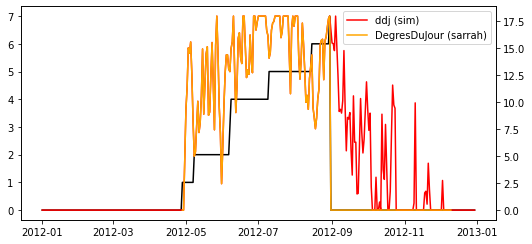

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


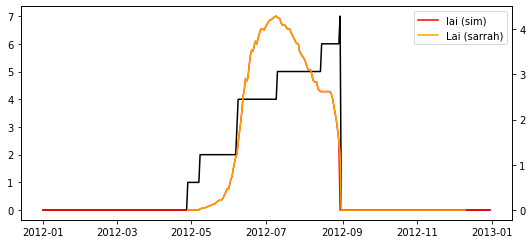

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


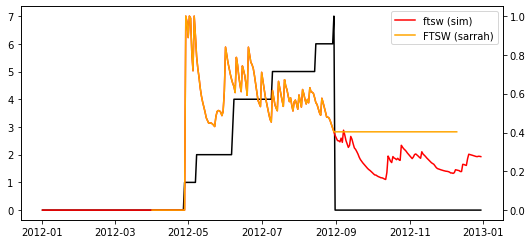

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


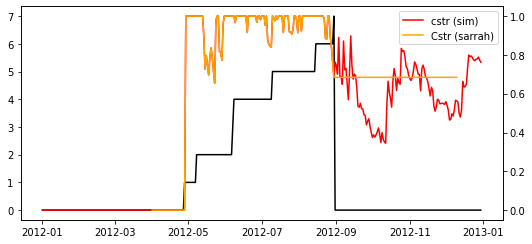

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


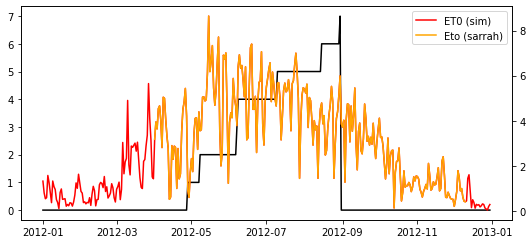

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


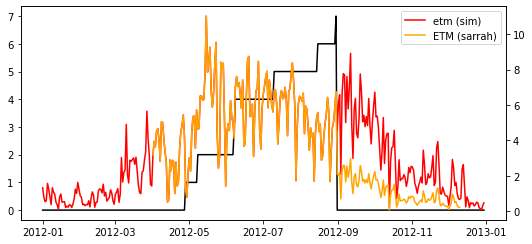

2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


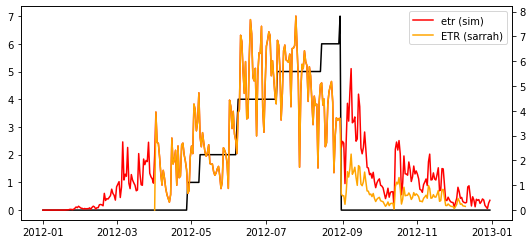

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


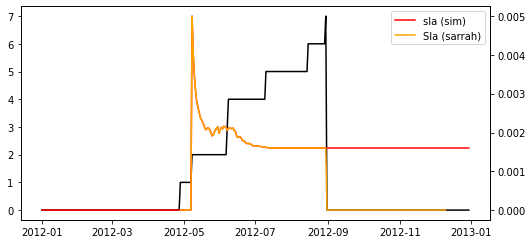

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


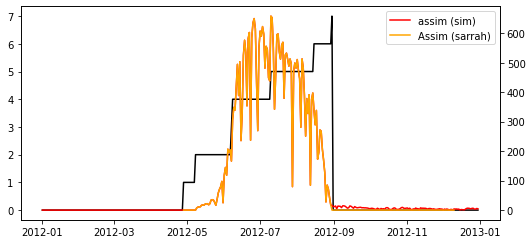

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


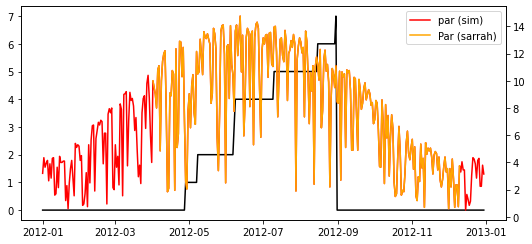

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


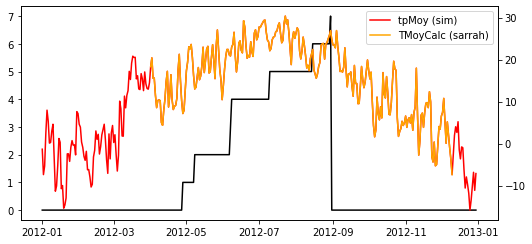

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


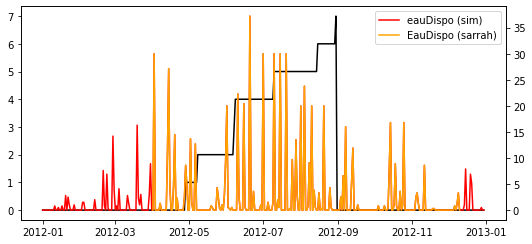

2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


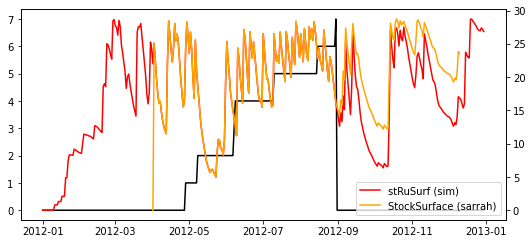

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


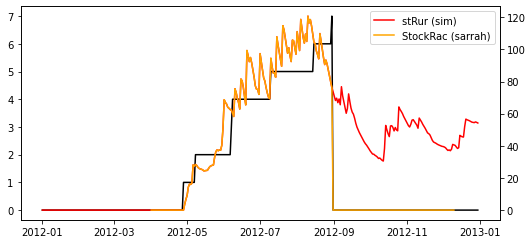

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


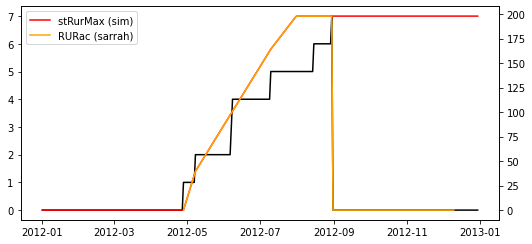

/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


2012-08-31


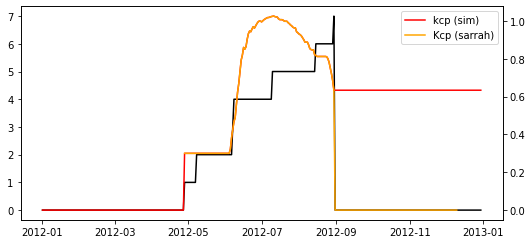

2012-09-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


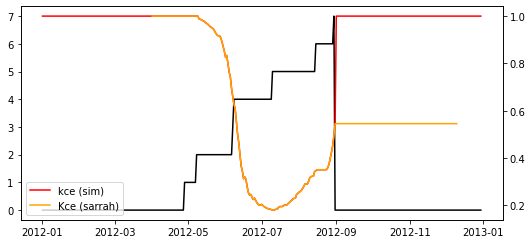

2012-09-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


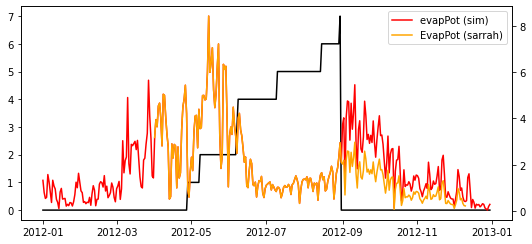

2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


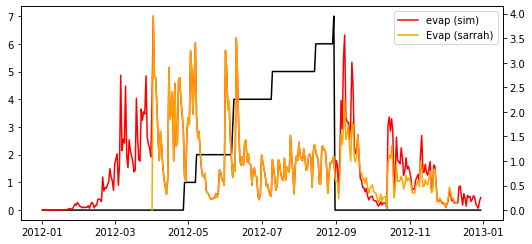

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


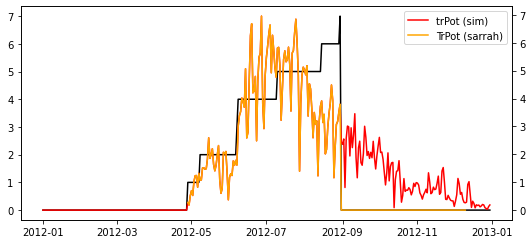

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


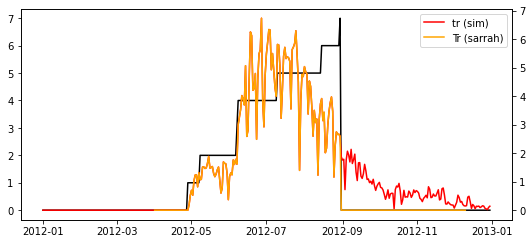

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


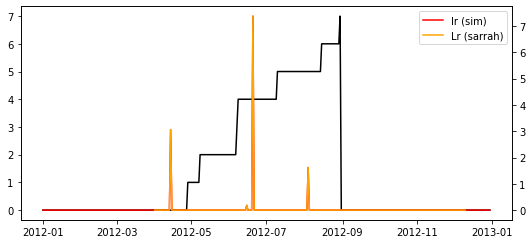

2012-04-02


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


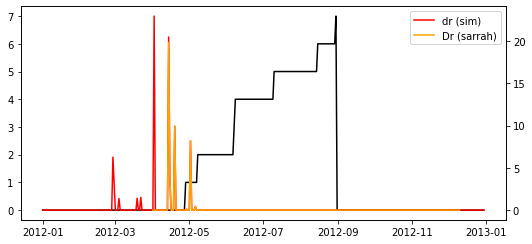

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


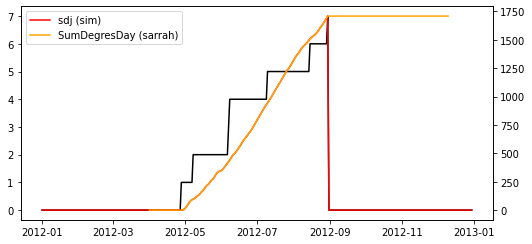

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


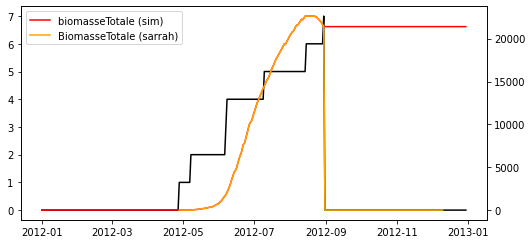

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


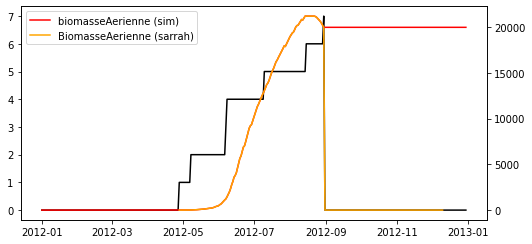

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


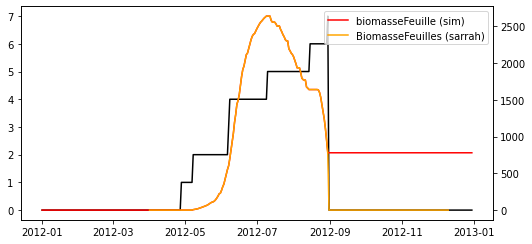

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


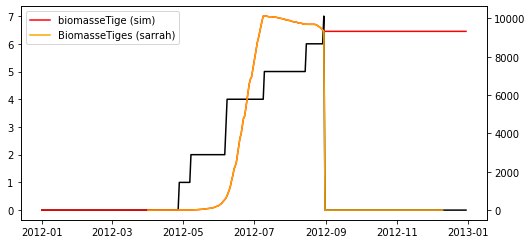

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


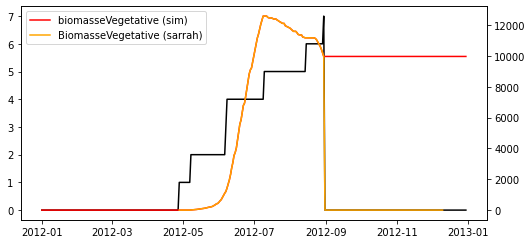

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


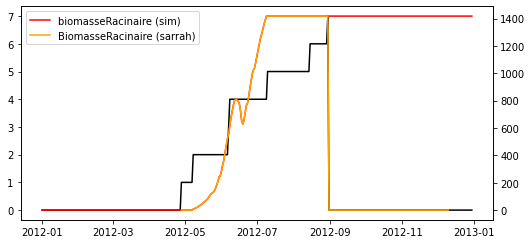

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


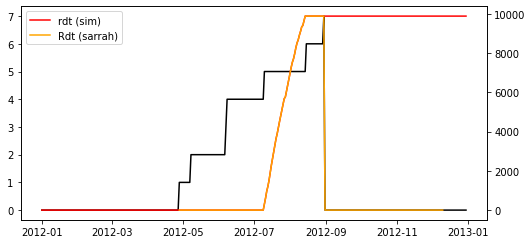

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


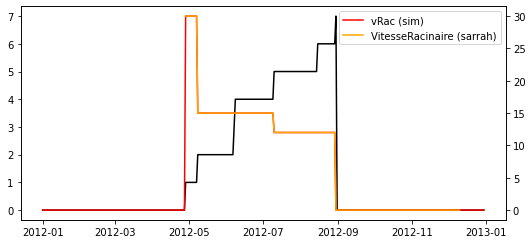

2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


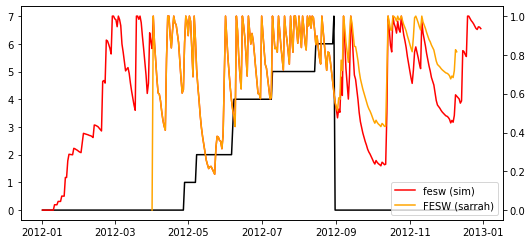

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


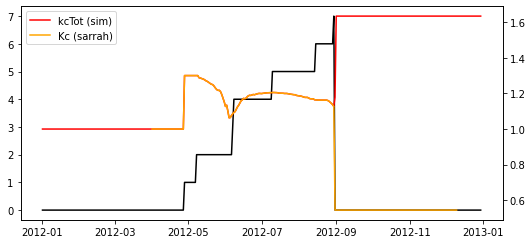

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


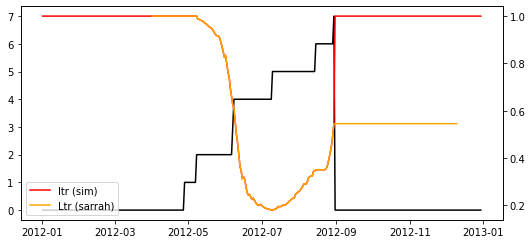

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


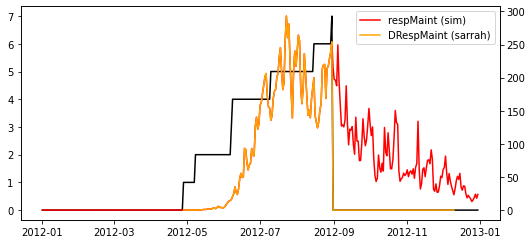

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


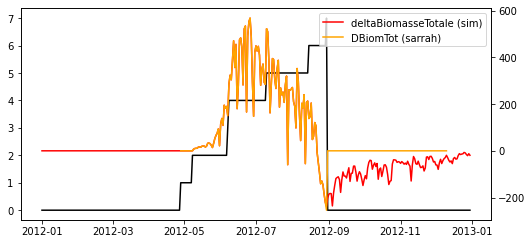

2012-08-15


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


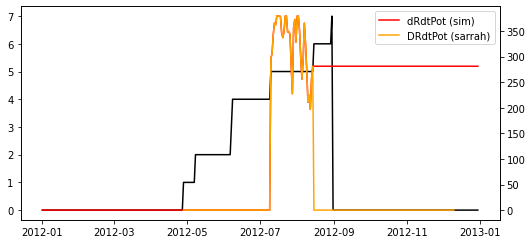

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


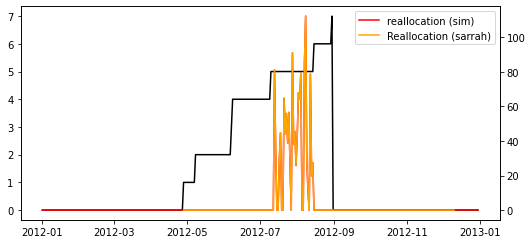

2012-08-31


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


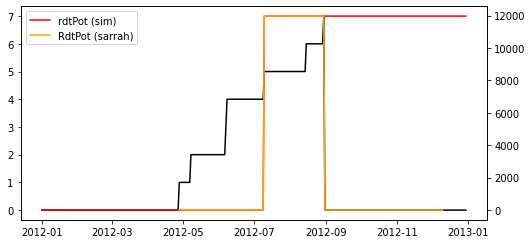

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


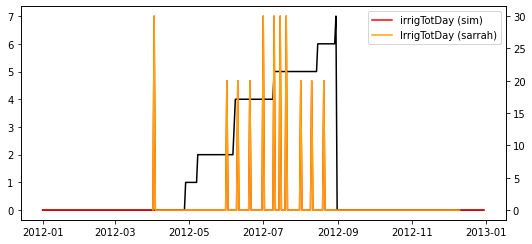

2012-08-30


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


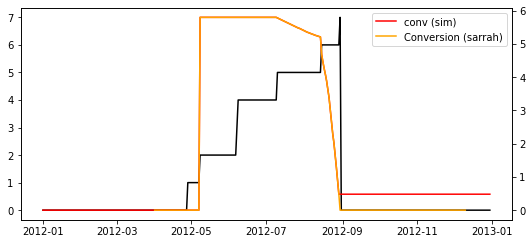

2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


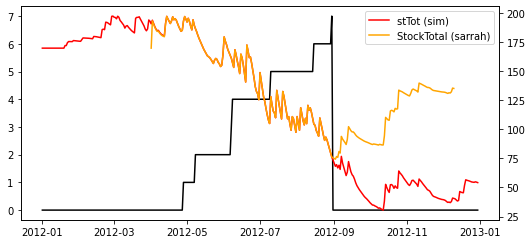

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


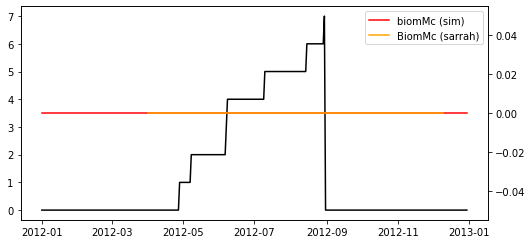

1990-01-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


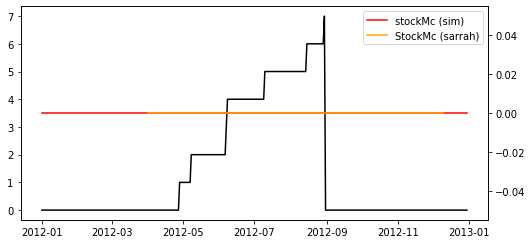

nan
nan
nan
nan
2012-04-01


/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_16820/1212108693.py:9: FutureWarning: The frame.append method is deprecated 

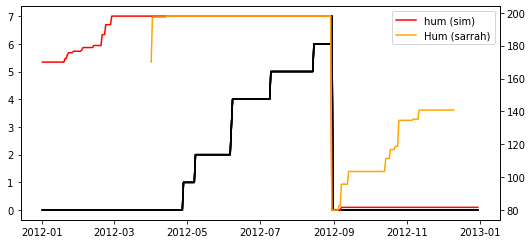

In [33]:
diff = pd.DataFrame()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        
        date, meandiff = compute_earliest_diff(var, var_correspondance[var])
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
        try:
            graph_comparison(var, var_correspondance[var])
        except:
            pass
    except:
        print(var,'failed')
        pass

In [34]:
diff.sort_values(by="earliest_diff")

,var,var2,earliest_diff,meandiff
0,BiomMc,biomMc,1990-01-01,0.000000e+00
0,IrrigTotDay,irrigTotDay,1990-01-01,0.000000e+00
0,Eto,ET0,1990-01-01,0.000000e+00
0,Reallocation,reallocation,1990-01-01,2.900861e-14
0,VitesseRacinaire,vRac,1990-01-01,0.000000e+00
0,Par,par,1990-01-01,0.000000e+00
0,TMoyCalc,tpMoy,1990-01-01,3.729246e-16
0,EauDispo,eauDispo,1990-01-01,1.398706e-17
0,StockMc,stockMc,1990-01-01,0.000000e+00
0,Lr,lr,1990-01-01,6.010066e-18
